# Parameter Recovery for the FCQ and MCQ measures

This notebook conducts parameter recovery simulations for the FCQ and MCQ measures, based on the hyperbolic discount function,

$$
V(R, D, k) = R \cdot \frac{1}{1+(k \cdot D)}
$$

where $R$ is a reward, delivered at a delay $D$. 

In order for this to be a meaningful parameter recovery excercise then the data generating model defined in `generate_responses` _must_ be exactly the same model that is used for inference in `infer_parameters`.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, bernoulli, uniform
import pymc3 as pm
import math

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'font.size': 10})
import matplotlib.ticker as ticker

# Initialize random number generator
np.random.seed(1234)

import sys
print("Python version:\n{}\n".format(sys.version))

Python version:
3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]



In [2]:
out_dir = 'output/'

Define parameters of the parameter recovery simulations

In [3]:
n_simulations = 100

export = True

sample_options = {'tune': 1000, 'draws': 2000,
                  'chains': 2, 'cores': 2,
                  'nuts_kwargs': {'target_accept': 0.95}}

## Define the core `parameter_recovery` function

In [4]:
def parameter_recovery(true_logk):
    '''
    Conducts parameter recovery for a single simulated experiment.
    Return a single row of a DataFrame which contains the true and recovered
    parameter values.
    '''
    params_true = pd.DataFrame({'logk': [true_logk]})
    expt_data = simulate_experiment(params_true)
    params_inferred = infer_parameters(expt_data)
    row_data = pd.concat([params_true, params_inferred], axis=1)
    return row_data

### Define these functions

Our set of true parameters will be generated in `generate_true_params`. These are sampled from normal distributions which equate to our prior beliefs over participant level $\log(k)$ and $\log(s)$ used in our parameter estimation step.

In [5]:
def simulate_experiment(params_true, ϵ=0.01):
    '''Run a simulated experiment, returning simulated behavioural data'''
    designs = delay_discounting_questions
    responses, _ = generate_responses(designs, params_true, ϵ)
    return pd.concat([designs, responses], axis=1)

def generate_responses(designs, params_true, ϵ):
    '''Generate simulated responses for the given designs and parameters'''
    
    # unpack designs
    RA = designs['RA'].values
    DA = designs['DA'].values
    RB = designs['RB'].values
    DB = designs['DB'].values
    
    # unpack parameters
    logk = params_true['logk'].values
    
    k = np.exp(logk)
    
    VA = RA * (1 / (1 + k*DA))
    VB = RB * (1 / (1 + k*DB))
    decision_variable = VB-VA
    p_choose_B = ϵ + (1 - 2 * ϵ) * (1 / (1 + np.exp(-1.7 * decision_variable)))
    responses = bernoulli.rvs(p_choose_B)
    return pd.DataFrame({'R': responses}), p_choose_B

In [6]:
def infer_parameters(data):
    '''Infer parameter values based on response data.
    Return the posterior mean parameter estimates'''
    
    model = generate_model(data)
    
    # do the inference
    with model:
        trace = pm.sample(**sample_options)
    
    return extract_info_from_trace(trace)


def generate_model(data):
    '''Generate a PyMC3 model with the given observed data'''
    
    # decant data
    R = data['R'].values
    RA, DA = data['RA'].values, data['DA'].values
    RB, DB = data['RB'].values, data['DB'].values
    
    with pm.Model() as model:
        # define priors
        logk = pm.Normal('logk', mu=-1.5, sd=3)
        
        VA = pm.Deterministic('VA', value_function(RA, DA, logk))
        VB = pm.Deterministic('VB', value_function(RB, DB, logk))
        P_chooseB = pm.Deterministic('P_chooseB', choice_psychometric(VB-VA))
        
        R = pm.Bernoulli('R', p=P_chooseB, observed=R)
        
    return model


# helper functions for the model

def value_function(reward, delay, logk):
    '''Calculate the present subjective value of a given prospect'''
    k = pm.math.exp(logk)
    return reward / (1.0+k*delay)

def choice_psychometric(x, ϵ=0.01):
    # x is the decision variable
    return ϵ + (1.0-2.0*ϵ) * (1/(1+pm.math.exp(-1.7*(x))))


def trace_quantiles(x):
    return pd.DataFrame(pm.quantiles(x, [2.5, 5, 50, 95, 97.5]))

def extract_info_from_trace(trace):
    '''Return a 1-row DataFrame of summary statistics (i.e. means, ranges)
    of the parameters of interest'''
    
    # useful PyMC3 function to get summary statistics
    summary = pm.summary(trace, ['logk'], credible_interval=0.95)
    logk = summary['mean']['logk']
    logkL = summary['hpd_2.5%']['logk']
    logkU = summary['hpd_97.5%']['logk']

    return pd.DataFrame({'logk_est': [logk], 'logk_est_L': [logkL], 'logk_est_U': [logkU]})

## Result plotting function

In [7]:
def plot_results(results, test_name, ax=None, units="[k in units of 1/days]"):
    plt.rcParams.update({'font.size': 14})

    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 6))

    tick_spacing = 1

    x = results['logk']
    y = results[f'logk_est']

    yerrL = results['logk_est'] - results['logk_est_L']
    yerrU = results['logk_est_U'] - results['logk_est']

    # line of equality
    ax.plot([np.min(x), np.max(x)], [np.min(x), np.max(x)], c='k')

    # errorbar
    ax.errorbar(x, y, yerr=[yerrL, yerrU], fmt='o', alpha=0.5)

    ax.set_xlabel(f'true $\ln(k)$\n{units}')
    ax.set_ylabel(f'estimated $\ln(k)$\n{units}')
    ax.grid()
    ax.set_title(test_name)
    #ax.set_aspect('equal', 'box')

    # set same tick spacing for both axes
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    plt.tight_layout()

## Conduct the parameter recovery simulations for MCQ
🔥 Warning: this will take some time to compute.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2486.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2353.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2554.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2

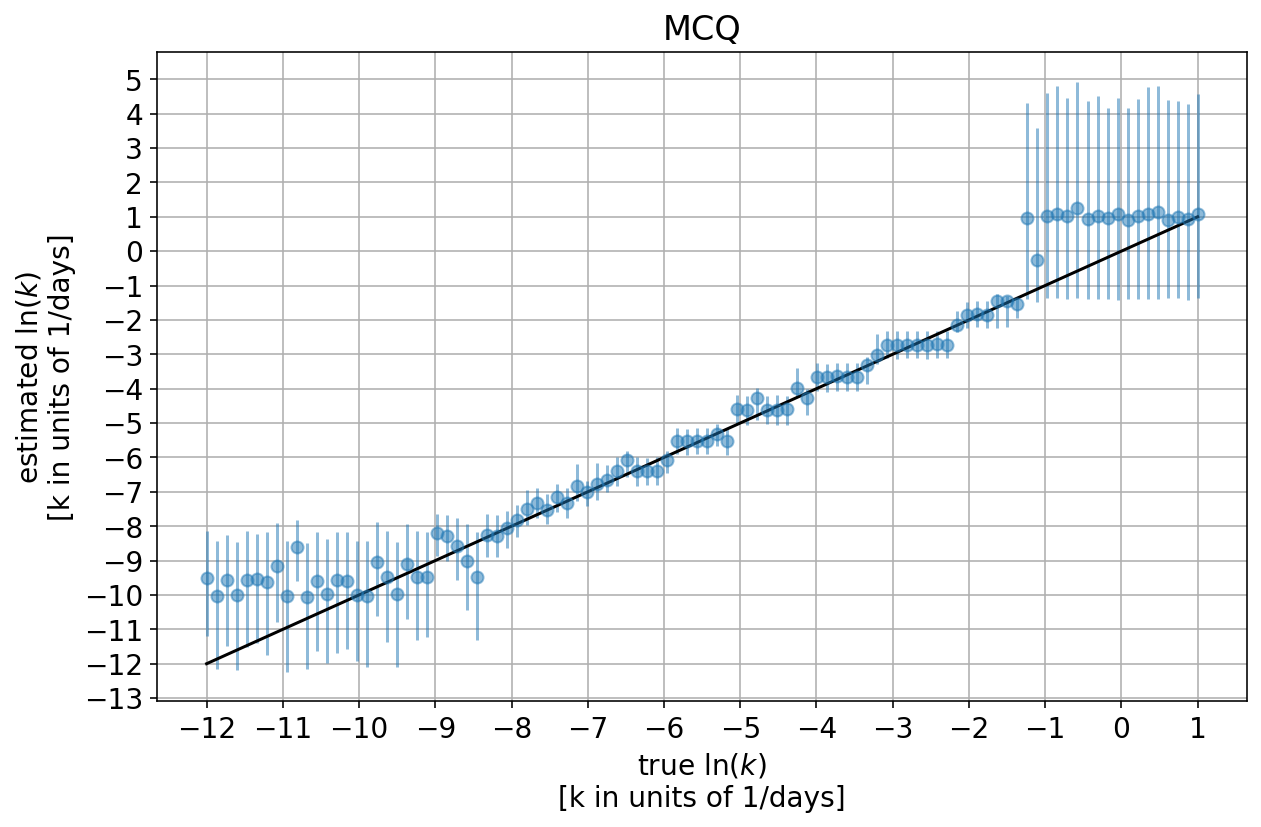

In [8]:
# load MCQ data
delay_discounting_questions = pd.read_csv("mcq_questions.csv")
delay_discounting_questions.head()

# define true logk values
true_logk = np.linspace(-12, +1, n_simulations)

# RUN THE PARAMETER RECOVERY
results_mcq = [parameter_recovery(logk) for logk in true_logk]
results_mcq = pd.concat(results_mcq, ignore_index=True)
results_mcq.head()

if export:
    results_mcq.to_csv(f'{out_dir}parameter_recovery_results_MCQ.csv')
    
# plot_results(results_mcq, 'MCQ', units="[k in units of 1/days]")
plot_results(results_mcq, "MCQ", ax=None, units="[k in units of 1/days]")

## Conduct the parameter recovery simulations for FCQ
🔥 Warning: this will take some time to compute.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1431.25draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1465.19draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2131.55draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2

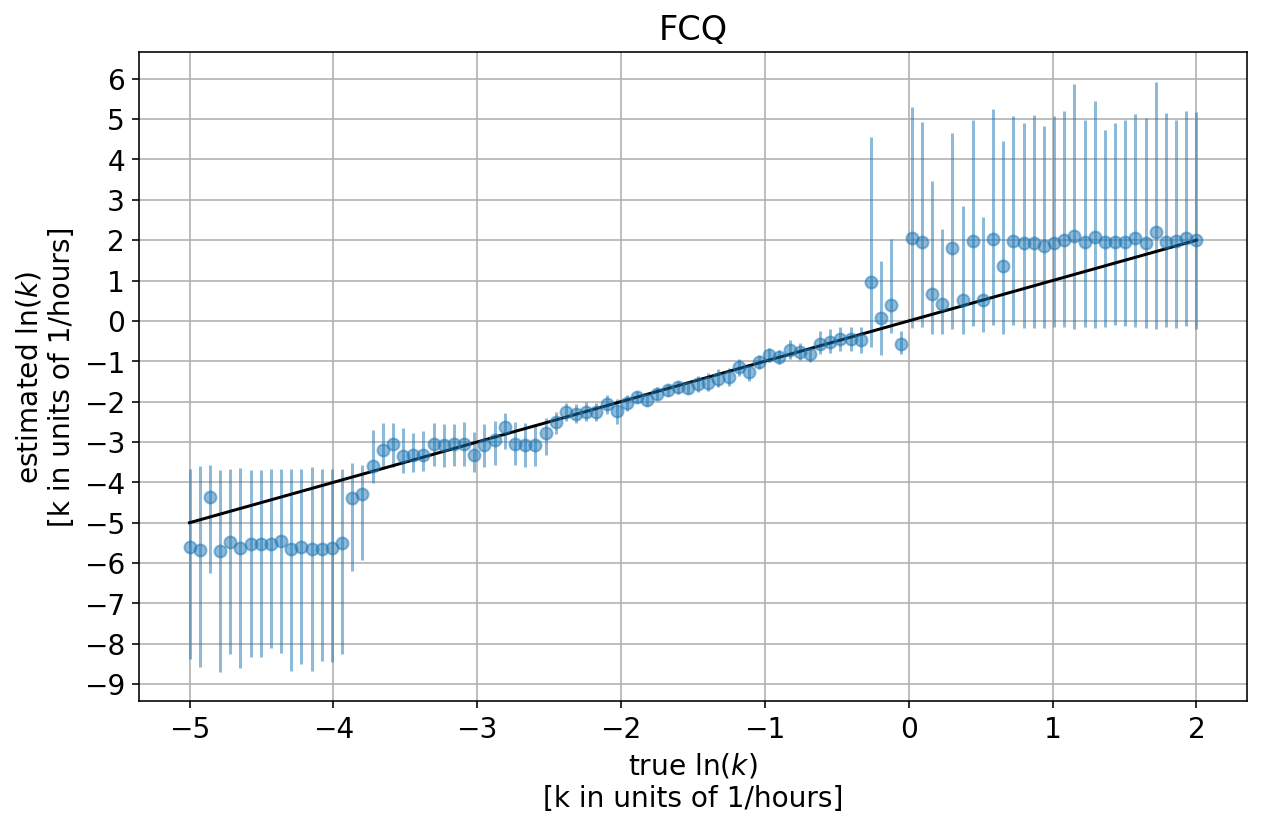

In [9]:
# load FCQ data
delay_discounting_questions = pd.read_csv("fcq_questions.csv")
delay_discounting_questions.head()

# define true logk values
true_logk = np.linspace(-5, 2, n_simulations)

# RUN THE PARAMETER RECOVERY
results_fcq = [parameter_recovery(logk) for logk in true_logk]
results_fcq = pd.concat(results_fcq, ignore_index=True)
results_fcq.head()

if export:
    results_fcq.to_csv(f'{out_dir}parameter_recovery_results_FCQ.csv')
    
# plot_results(results_fcq, 'FCQ', units="[k in units of 1/hours]")
plot_results(results_fcq, "FCQ", ax=None, units="[k in units of 1/hours]")

## Conduct the parameter recovery simulations for Lim & Bruce (2015) WCQ
🔥 Warning: this will take some time to compute.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2432.88draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2358.51draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2481.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2

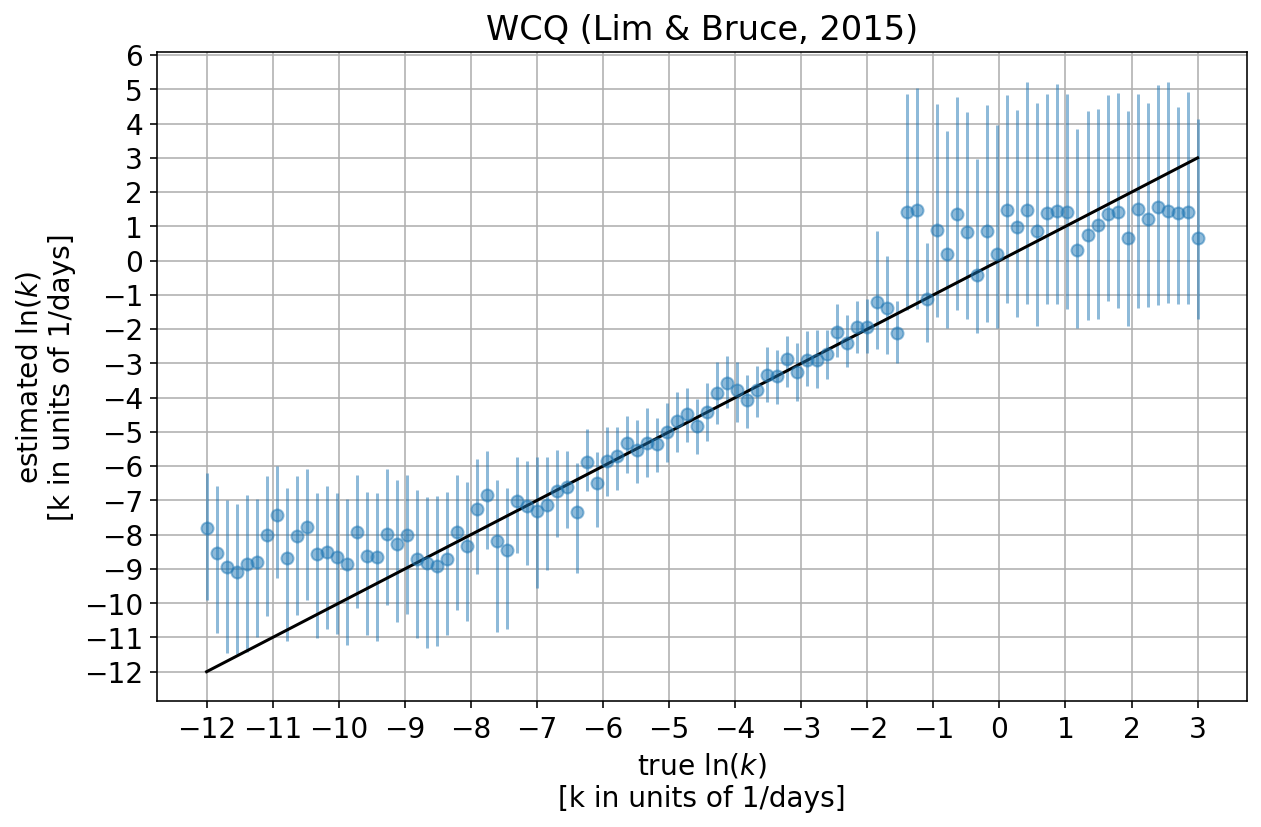

In [10]:
# load WCQ data
delay_discounting_questions = pd.read_csv("lim_bruce_wcq_questions.csv")
delay_discounting_questions.head()

# define true logk values
true_logk = np.linspace(-12, +3, n_simulations)

# RUN THE PARAMETER RECOVERY
results_LBwcq = [parameter_recovery(logk) for logk in true_logk]
results_LBwcq = pd.concat(results_LBwcq, ignore_index=True)
results_LBwcq.head()

if export:
    results_LBwcq.to_csv(f'{out_dir}parameter_recovery_results_lim_brice_WCQ.csv')
    
plot_results(results_LBwcq, "WCQ (Lim & Bruce, 2015)", ax=None, units="[k in units of 1/days]")

## Conduct the parameter recovery simulations for WCQ
🔥 Warning: this will take some time to compute.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2513.17draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2582.52draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2703.07draws/s]
The acceptance probability does not match the target. It is 0.704257747967853, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples i

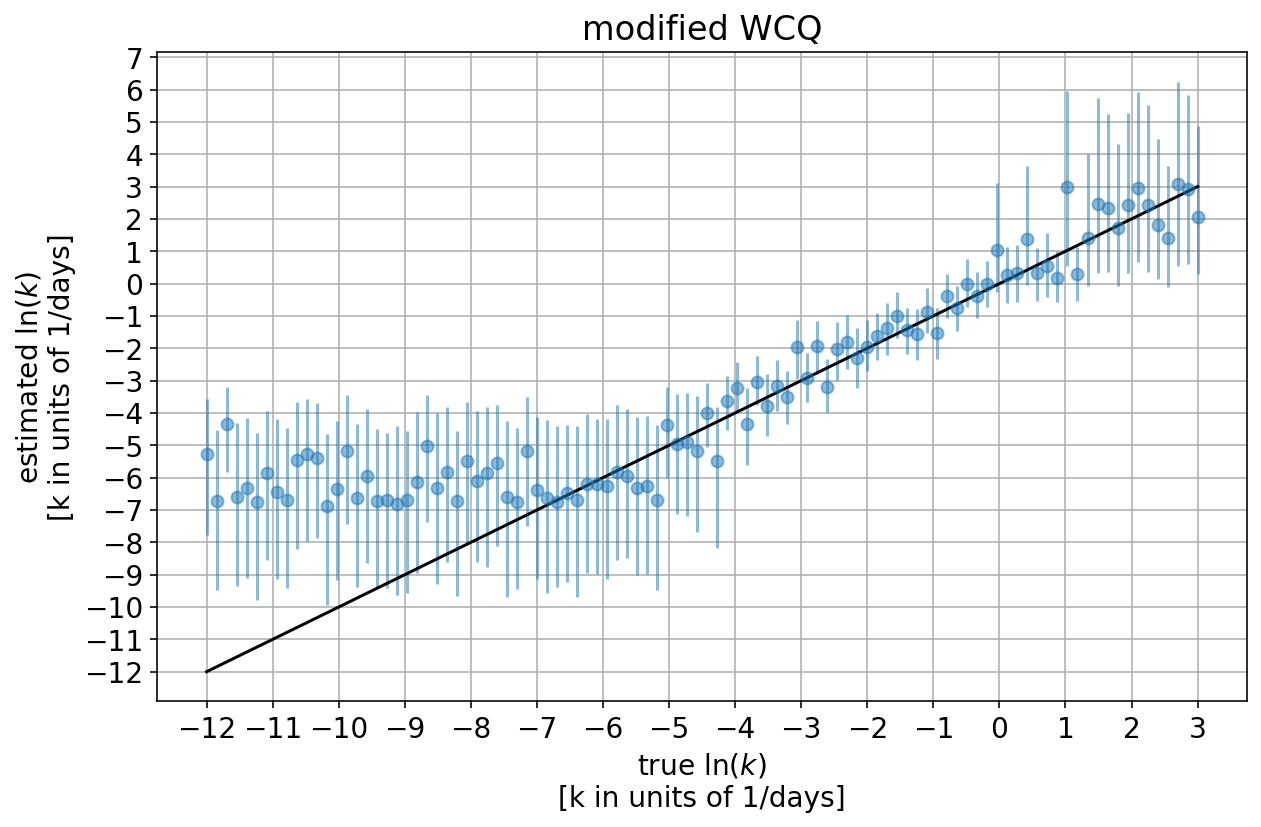

In [11]:
# load WCQ data
delay_discounting_questions = pd.read_csv("modified_wcq_questions.csv")
delay_discounting_questions.head()

# define true logk values
true_logk = np.linspace(-12, +3, n_simulations)

# RUN THE PARAMETER RECOVERY
results_Mwcq = [parameter_recovery(logk) for logk in true_logk]
results_Mwcq = pd.concat(results_Mwcq, ignore_index=True)
results_Mwcq.head()

if export:
    results_Mwcq.to_csv(f'{out_dir}parameter_recovery_results_modifiedWCQ.csv')
    
plot_results(results_Mwcq, "modified WCQ", ax=None, units="[k in units of 1/days]")

# Create combined figure

In [12]:
def plot_questions(data, ax=None):
    ax.scatter(data.DB, data.RA/data.RB, c="k")
    ax.set(xlabel="time until delayed reward", ylabel="immediate / delayed reward", ylim=[0, 1])
    ax.set_xlim(left=0)

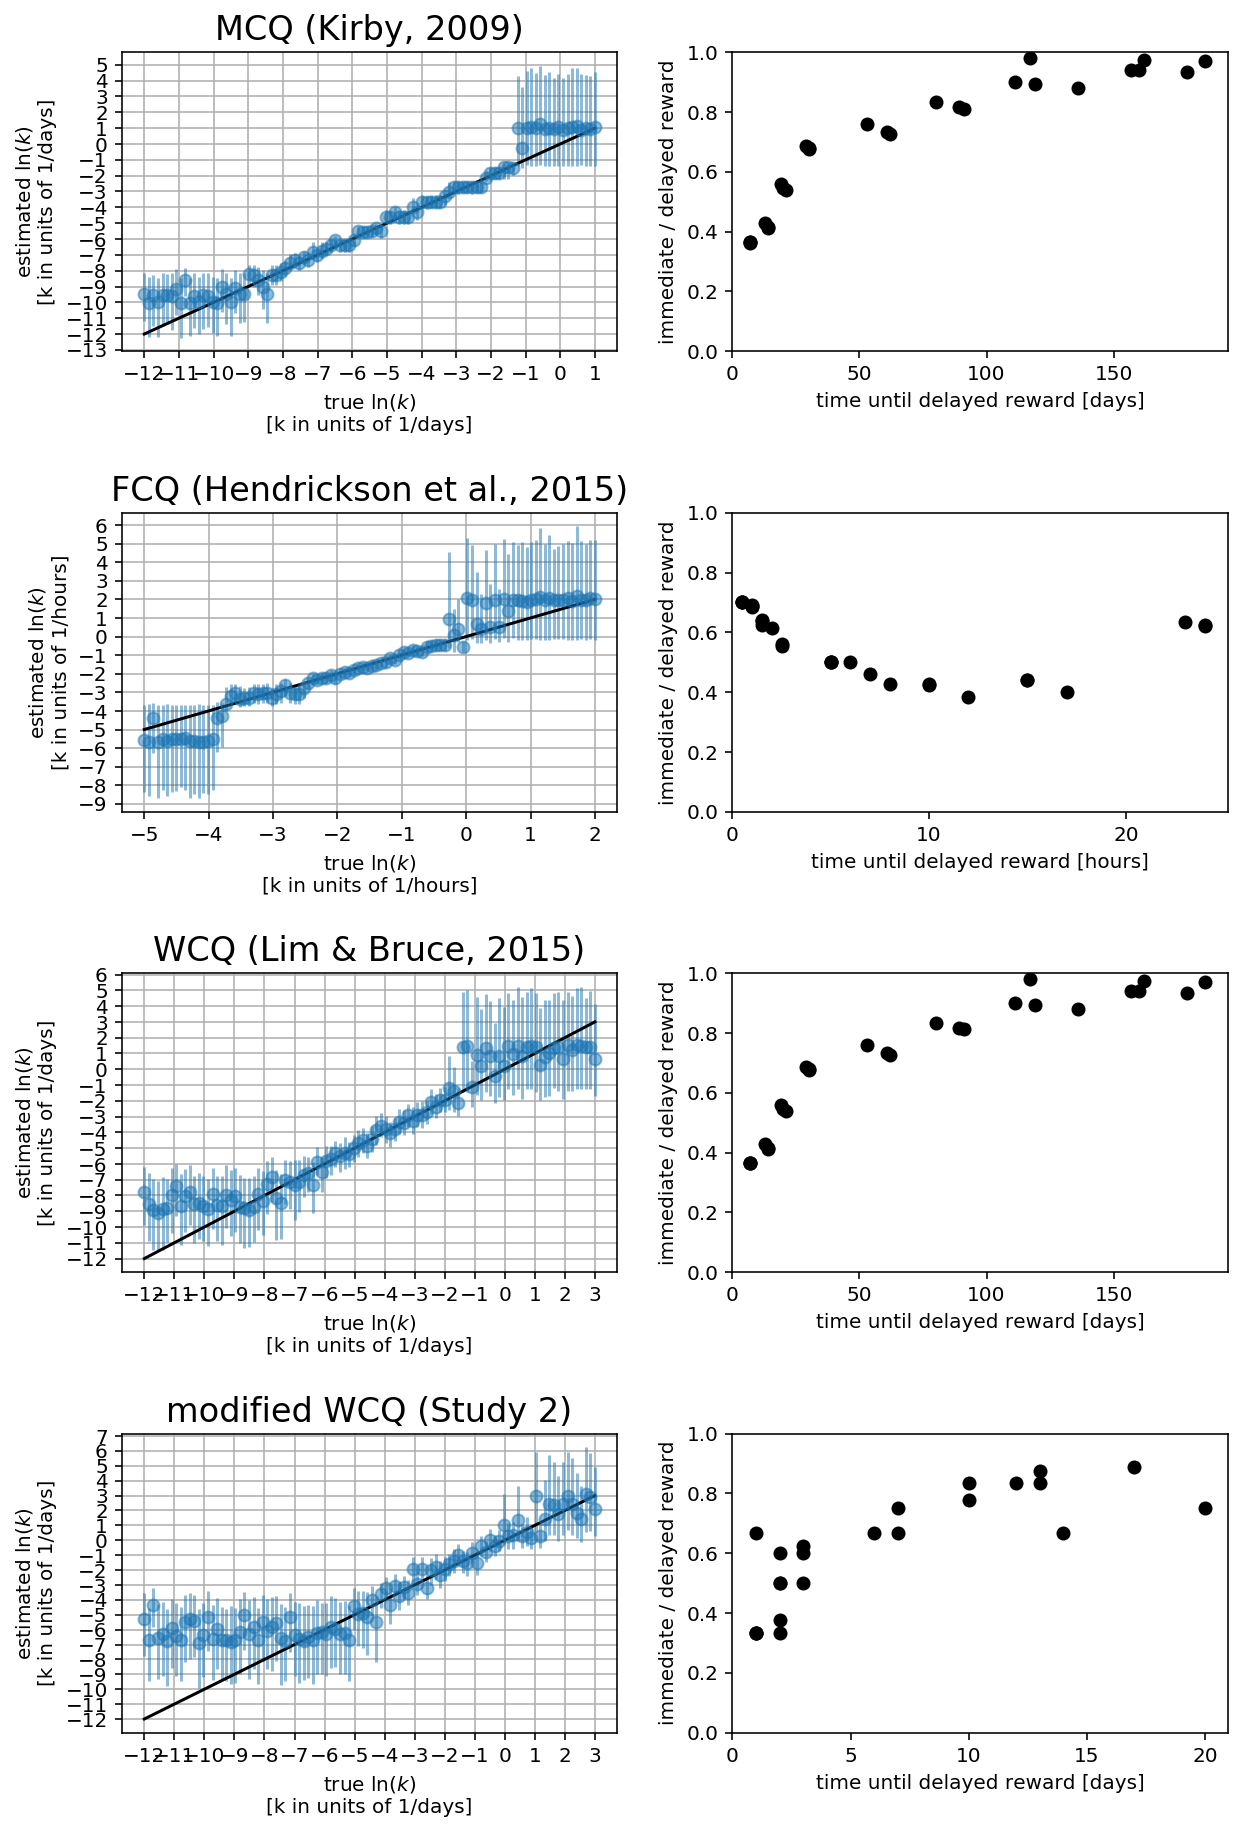

In [13]:
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(4, 2, figsize=(9, 13))

# MCQ
plot_results(results_mcq, "MCQ (Kirby, 2009)", ax=ax[0, 0], units="[k in units of 1/days]")
delay_discounting_questions = pd.read_csv("mcq_questions.csv")
plot_questions(delay_discounting_questions, ax=ax[0, 1])
ax[0,1].set(xlabel="time until delayed reward [days]")

plot_results(results_fcq, "FCQ (Hendrickson et al., 2015)", ax=ax[1, 0], units="[k in units of 1/hours]")
delay_discounting_questions = pd.read_csv("fcq_questions.csv")
plot_questions(delay_discounting_questions, ax=ax[1, 1])
ax[1,1].set(xlabel="time until delayed reward [hours]")

plot_results(results_LBwcq, "WCQ (Lim & Bruce, 2015)", ax=ax[2,0], units="[k in units of 1/days]")
delay_discounting_questions = pd.read_csv("lim_bruce_wcq_questions.csv")
plot_questions(delay_discounting_questions, ax=ax[2, 1])
ax[2,1].set(xlabel="time until delayed reward [days]")

plot_results(results_Mwcq, "modified WCQ (Study 2)", ax=ax[3,0], units="[k in units of 1/days]")
delay_discounting_questions = pd.read_csv("modified_wcq_questions.csv")
plot_questions(delay_discounting_questions, ax=ax[3, 1])
ax[3,1].set(xlabel="time until delayed reward [days]")

plt.savefig(f'{out_dir}parameter_recovery.pdf', bbox_inches='tight')